Mount drive to run on Google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#change directory to folder containing the zipped image folder
%cd /content/drive/MyDrive/Dsa4266/xray_pneumonia_train

/content/drive/MyDrive/Dsa4266/xray_pneumonia_train


In [ ]:
#unzip folder here for faster computation time on google colab
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2675017-0002.jpeg  
  inflating: train/NORMAL/NORMAL-2689107-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2692080-0001.jpeg  
  inflating: train/NORMAL/NORMAL-2695944-0001.jpe

In [ ]:
#install required library
!pip install torchxrayvision opencv-python optuna seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.8 MB/s eta 0:00:00


In [ ]:
from glob import glob
total = len(glob("train/*/*.jpeg"))
normal = len(glob("train/NORMAL/*.jpeg"))
pneu = len(glob("train/PNEUMONIA/*.jpeg"))

In [ ]:
#print number of images 
print(total)
print(normal)
print(pneu)

5232
1349
3883


In [ ]:
#libraries for training
import torch
import torch.optim as optim
import torchvision
import torchxrayvision as xrv

#for loading images
from torch.utils.data import Dataset, DataLoader
import cv2

#for tuning
import optuna

#for array
import numpy as np

#for plotting
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
#set device to cuda to run using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
for i in range(torch.cuda.device_count()):
        device_name = f'cuda:{i}'
        print(f'{i} device name:{torch.cuda.get_device_name(torch.device(device_name))}')

0 device name:Tesla T4


# Loading dataset
Customised data is required as the ImageFolder of pytorch does not allow scaling the pixels of the image to the desired value required for training the pre-trained model.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "train/"
        file_list = glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob(class_path + "/*.jpeg"):
                self.data.append([img_path, class_name])
        self.class_map = {"NORMAL" : 0, "PNEUMONIA": 1}

        #dimension 224*224 for DenseNet
        self.img_dim = (224,224)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path,0)  #greyscale image as the model requires
        img = cv2.resize(img, self.img_dim)  #resize to 224*224
        class_id = self.class_map[class_name]
        
        #scale the pixel between [-1024,1024] as model requires 
        img = (2 * img.astype(np.float32)/255 - 1.) * 1024    
        
        img_tensor = torch.from_numpy(img).unsqueeze(0)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [ ]:
dataset = CustomDataset()

In [ ]:
list(dataset.class_map.keys())

['NORMAL', 'PNEUMONIA']

In [ ]:
#train-validation split
trainData, valData = torch.utils.data.random_split(dataset,[0.7,0.3])

In [ ]:
train_dataloader = torch.utils.data.DataLoader(trainData, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valData, batch_size=8, shuffle=True)

# Model training
The pre-trained model chose is trained on all the available datasets in the torchxrayvision library.

In [ ]:
#set model weights to that of the pre-trained model trained on all dataset available on TorchXRayVision
model = xrv.models.DenseNet(weights="densenet121-res224-all").cuda()
model.op_threshs = None # prevent pre-trained model calibration
model.classifier = torch.nn.Linear(1024,1).cuda() # reinitialize classifier and 1 output

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001) # only train classifier
criterion = torch.nn.BCEWithLogitsLoss()

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [ ]:
for epoch in range(20):

    for i, batch in enumerate(train_dataloader):
    
        running_loss = 0

        data, label = batch

        data,label = data.to(device), label.to(device)  #transfer tensor to cuda 
        outputs = model(data) 
        targets = label 
        optimizer.zero_grad()   #prevent accumulating gradient from previous dataloader loop to update model parameters properly
        loss = criterion(outputs, targets.float())
        loss.backward()    #Back Propagation
        optimizer.step()

        running_loss += loss.detach().cpu().numpy()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.6f}')
            running_loss = 0.0

[1,   200] loss: 0.001289
[1,   400] loss: 0.000947
[2,   200] loss: 0.001282
[2,   400] loss: 0.000538
[3,   200] loss: 0.000841
[3,   400] loss: 0.001502
[4,   200] loss: 0.000389
[4,   400] loss: 0.000475
[5,   200] loss: 0.000169
[5,   400] loss: 0.000382
[6,   200] loss: 0.000198
[6,   400] loss: 0.000403
[7,   200] loss: 0.000123
[7,   400] loss: 0.000390
[8,   200] loss: 0.000093
[8,   400] loss: 0.000317
[9,   200] loss: 0.000274
[9,   400] loss: 0.000140
[10,   200] loss: 0.003253
[10,   400] loss: 0.000046
[11,   200] loss: 0.000130
[11,   400] loss: 0.000070
[12,   200] loss: 0.002329
[12,   400] loss: 0.001101
[13,   200] loss: 0.000099
[13,   400] loss: 0.000900
[14,   200] loss: 0.000182
[14,   400] loss: 0.000024
[15,   200] loss: 0.000055
[15,   400] loss: 0.000684
[16,   200] loss: 0.000091
[16,   400] loss: 0.000392
[17,   200] loss: 0.000425
[17,   400] loss: 0.001080
[18,   200] loss: 0.000159
[18,   400] loss: 0.000231
[19,   200] loss: 0.000065
[19,   400] loss: 0

# Model validation

In [ ]:
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,precision_score,recall_score,accuracy_score,roc_curve

In [ ]:
preds = []
actual = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        
        loss += criterion(outputs, labels.float())

        #predict pneumonia positive if output is more than 0.5
        for predict in torch.sigmoid(outputs).cpu().detach().numpy():
            predicted = 1 if predict > 0.5 else 0
            preds.append(predicted)
          
        
        actual.extend(labels.cpu().detach().numpy().tolist())
        
    #calculate validation loss
    val_loss = loss / len(val_dataloader)
    print(val_loss)


TN, FP, FN, TP = confusion_matrix(actual,preds).ravel()
print(TN,FP,FN,TP)

tensor(0.0692, device='cuda:0')
373 17 17 1162


True Positive Rate:  0.9855810008481765
True Negative Rate 0.9564102564102565
False Positive Rate:  0.04358974358974359
False Negative Rate:  0.01441899915182358
Accuracy:  0.9783301465901848
Precision:  0.9855810008481765
False Discovery Rate:  0.01441899915182358
Negative Predictive:  0.9564102564102565


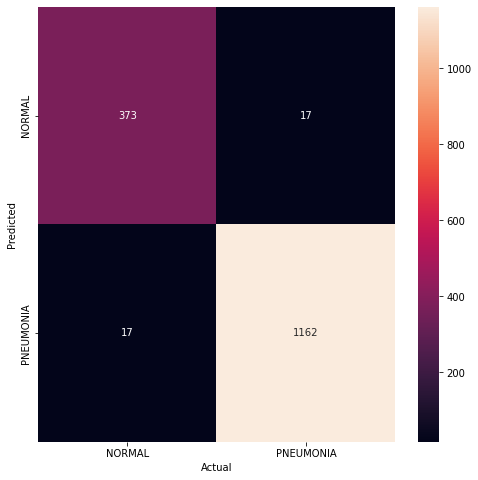

In [ ]:
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns_hmp = sns.heatmap([[TN,FN],[FP,TP]], annot=True, xticklabels = [list(dataset.class_map.keys())[i] for i in range(len(list(dataset.class_map.keys())))], 
                      yticklabels = [list(dataset.class_map.keys())[i] for i in range(len(list(dataset.class_map.keys())))], fmt="d")
  
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig = sns_hmp.get_figure()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate: ", TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate", TNR)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate: ", FPR)
# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy: ", ACC)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision: ", PPV)
# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate: ", FNR)
# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive: ", NPV)

In [ ]:
roc_auc_score(actual,preds)

0.9709956286292165

In [ ]:
f1_score(actual,preds)

0.9855810008481765

In [ ]:
recall_score(actual,preds)

0.9855810008481765

In [ ]:
precision_score(actual,preds)

0.9855810008481765

# DenseNet121 model architecture

In [ ]:
torchvision.models.densenet121()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Hyperparameter tuning with optuna
This is an attempt on tuning the model using optuna. As every trial takes about 20-30 minutes, only a few trials was done. Therefore, the result from this may not be the best set of hyperparameters, and it could even be worse than the above model.

In [ ]:
def train_and_evaluate(params,model):

    #set hyperparameter
    train_dataloader_tune = torch.utils.data.DataLoader(trainData, batch_size=params['batch_size'], shuffle=True)
    val_dataloader_tune = torch.utils.data.DataLoader(valData, batch_size=params['batch_size'], shuffle=True) 

    optimizer = getattr(optim, params['optimizer'])(model.classifier.parameters(), lr=params['learning_rate'])   # only train classifier
    criterion = torch.nn.BCEWithLogitsLoss()
    

    for epoch in range(20):

        for i, batch in enumerate(train_dataloader_tune):
        
            data, label = batch
            data,label = data.to(device), label.to(device)
            outputs = model(data) 
            targets = label 
            optimizer.zero_grad()    #prevent accumulating gradient from previous training loop to update model parameters properly
            loss = criterion(outputs, targets.float())
            loss.backward()    #back propagation
            optimizer.step()

            
        
    preds = []
    actual = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_dataloader_tune:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)

            #predict pneumonia positive if output is more than 0.5
            for predict in torch.sigmoid(outputs).cpu().detach().numpy():
                predicted = 1 if predict > 0.5 else 0
                preds.append(predicted)

            actual.extend(labels.cpu().detach().numpy().tolist())
          
    acc = accuracy_score(actual,preds)

    return acc

def objective(trial):

    #define hyperparameter
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
              'batch_size': trial.suggest_categorical('batch_size', [4,8,16,32])
              }
    
    model = xrv.models.DenseNet(weights="densenet121-res224-all").cuda()
    model.op_threshs = None # prevent pre-trained model calibration
    model.classifier = torch.nn.Linear(1024,1).cuda() # reinitialize classifier and 1 output
    
    acc = train_and_evaluate(params, model)

    return acc


only did a few trials because tuning takes too long

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=5)

[I 2023-02-09 12:08:09,726] A new study created in memory with name: no-name-4803e8bd-4670-4100-91d1-5afcccb39942
[I 2023-02-09 12:32:01,230] Trial 0 finished with value: 0.7450605481198216 and parameters: {'learning_rate': 1.0695294999039368e-05, 'optimizer': 'SGD', 'batch_size': 8}. Best is trial 0 with value: 0.7450605481198216.
[I 2023-02-09 12:55:33,737] Trial 1 finished with value: 0.7488846398980242 and parameters: {'learning_rate': 8.35100603253082e-05, 'optimizer': 'SGD', 'batch_size': 8}. Best is trial 1 with value: 0.7488846398980242.
[I 2023-02-09 13:19:11,768] Trial 2 finished with value: 0.8884639898024219 and parameters: {'learning_rate': 0.0003166320979380127, 'optimizer': 'SGD', 'batch_size': 8}. Best is trial 2 with value: 0.8884639898024219.
[I 2023-02-09 13:38:22,946] Trial 3 finished with value: 0.9260675589547482 and parameters: {'learning_rate': 4.0103173469913434e-05, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 3 with value: 0.9260675589547482.
[I 2023

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.05182265755045296
optimizer: SGD
batch_size: 4


# Retrain model with 'best' set of hyper parameters selected by optuna

In [ ]:
model = xrv.models.DenseNet(weights="densenet121-res224-all").cuda()
model.op_threshs = None # prevent pre-trained model calibration
model.classifier = torch.nn.Linear(1024,1).cuda() # reinitialize classifier and 1 output

optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.05182265755045296) 
criterion = torch.nn.BCEWithLogitsLoss()

train_dataloader = torch.utils.data.DataLoader(trainData, batch_size=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valData, batch_size=4, shuffle=True)

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [ ]:
for epoch in range(20):

    for i, batch in enumerate(train_dataloader):
    
        running_loss = 0

        data, label = batch

        data,label = data.to(device), label.to(device)
        outputs = model(data) 
        targets = label 
        optimizer.zero_grad()
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.detach().cpu().numpy()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.6f}')
            running_loss = 0.0

[1,   200] loss: 0.002796
[1,   400] loss: 0.000182
[1,   600] loss: 0.002399
[1,   800] loss: 0.000440
[2,   200] loss: 0.002299
[2,   400] loss: 0.001371
[2,   600] loss: 0.000135
[2,   800] loss: 0.001857
[3,   200] loss: 0.000683
[3,   400] loss: 0.000521
[3,   600] loss: 0.001217
[3,   800] loss: 0.000636
[4,   200] loss: 0.000305
[4,   400] loss: 0.000641
[4,   600] loss: 0.000165
[4,   800] loss: 0.000125
[5,   200] loss: 0.000090
[5,   400] loss: 0.000153
[5,   600] loss: 0.000024
[5,   800] loss: 0.000988
[6,   200] loss: 0.000206
[6,   400] loss: 0.000520
[6,   600] loss: 0.000434
[6,   800] loss: 0.000239
[7,   200] loss: 0.000044
[7,   400] loss: 0.000999
[7,   600] loss: 0.000033
[7,   800] loss: 0.000088
[8,   200] loss: 0.000054
[8,   400] loss: 0.003219
[8,   600] loss: 0.000488
[8,   800] loss: 0.000187
[9,   200] loss: 0.000092
[9,   400] loss: 0.000380
[9,   600] loss: 0.000050
[9,   800] loss: 0.000121
[10,   200] loss: 0.000006
[10,   400] loss: 0.000012
[10,   600

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Dsa4266/xray_pneumonia_train/save_tune")

In [ ]:
preds = []
actual = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)

        loss += criterion(outputs, labels.float())

        for predict in torch.sigmoid(outputs).cpu().detach().numpy():
            predicted = 1 if predict > 0.5 else 0
            preds.append(predicted)
          
        
        actual.extend(labels.cpu().detach().numpy().tolist())
        
    #calculate validation loss
    val_loss = loss / len(val_dataloader)
    print(val_loss)


TN, FP, FN, TP = confusion_matrix(actual,preds).ravel()
print(TN, FP, FN, TP)

tensor(0.0671, device='cuda:0')
366 20 15 1168


In [ ]:
auc_torch = roc_auc_score(actual,preds)

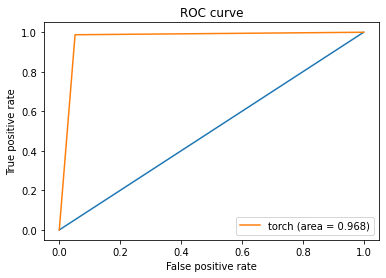

In [ ]:
fpr, tpr, _ = roc_curve(actual, preds)

plt.figure(1)
plt.plot([0, 1], [0, 1], '-')
plt.plot(fpr, tpr, label='torch (area = {:.3f})'.format(auc_torch))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
                             

True Positive Rate:  0.9873203719357565
True Negative Rate 0.9481865284974094
False Positive Rate:  0.05181347150259067
False Negative Rate:  0.01267962806424345
Accuracy:  0.9776927979604844
Precision:  0.9831649831649831
False Discovery Rate:  0.01267962806424345
Negative Predictive:  0.9606299212598425


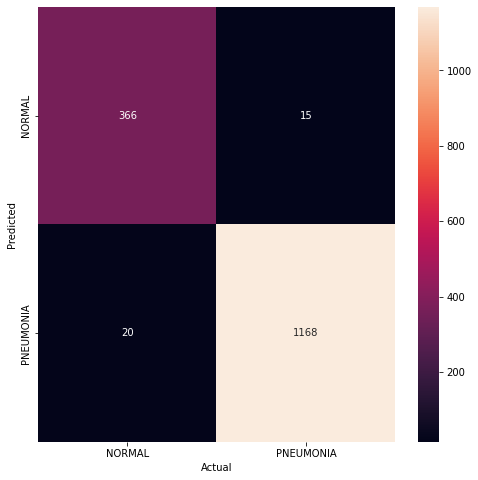

In [ ]:
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns_hmp = sns.heatmap([[TN,FN],[FP,TP]], annot=True, xticklabels = [list(dataset.class_map.keys())[i] for i in range(len(list(dataset.class_map.keys())))], 
                      yticklabels = [list(dataset.class_map.keys())[i] for i in range(len(list(dataset.class_map.keys())))], fmt="d")
  
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig = sns_hmp.get_figure()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate: ", TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate", TNR)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate: ", FPR)
# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy: ", ACC)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision: ", PPV)
# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate: ", FNR)
# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive: ", NPV)